# Setup

In [1]:
# General libraries
import pandas as pd
import numpy as np

# Utilities
from pathlib import Path
import psutil
import gc
import os

# Cuda
import torch

In [2]:
# Warnings
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Suppress the specific PerformanceWarning
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Pd options
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

In [3]:
# Get the number of available CPUs
num_cpus = os.cpu_count()

# Show
print(num_cpus)

16


In [4]:
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. Using GPU.")
else:
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


# Directory

In [5]:
# Set the right directory
current_path = Path.cwd()
if current_path.name in ['notebooks', 'src']:
    os.chdir('..')
    print(f"Moved up from {current_path.name} to: {os.getcwd()}")
else:
    print(f"Already in project directory: {os.getcwd()}")

Moved up from notebooks to: c:\Local\Forecaster


# Assets

In [6]:
# Import assets
from utils.data_preparation import DataPreparation
from utils.feature_engineering import FeatureEngineering
from utils.create_baselines import CreateBaselines
from utils.forecaster import Forecaster
from utils.guardrail import Guardrail
from utils.evaluator import Evaluator
from utils.auxiliar import *

# Load data

In [7]:
# Raw URL of the CSV file
url = 'https://raw.githubusercontent.com/ipveka/Forecaster/main/data/example.csv'

# Load the CSV into a DataFrame
df_input = pd.read_csv(url)

# Ensure the 'data' folder exists
os.makedirs('data', exist_ok=True)

# Save DataFrame as CSV locally
df_input.to_csv('data/example.csv', index=False)

# Show
df_input.head()

,id,date,year_week,product_number,reporterhq_id,prod_category,specs,display_size,segment,sales_units,inventory_units
0,202224-2961,2022-06-18,202224,2961,15,Doraemon,186631,15.6,Gaming,52.0,88.0
1,202225-2961,2022-06-25,202225,2961,15,Doraemon,186631,15.6,Gaming,6.0,88.0
2,202226-2961,2022-07-02,202226,2961,15,Doraemon,186631,15.6,Gaming,60.0,138.0
3,202227-2961,2022-07-09,202227,2961,15,Doraemon,186631,15.6,Gaming,158.0,65.0
4,202228-2961,2022-07-16,202228,2961,15,Doraemon,186631,15.6,Gaming,23.0,30.0


## Formatting

In [8]:
# Convert all column names to lowercase
df_input.columns = df_input.columns.str.lower()

# Date format
df_input['date'] = pd.to_datetime(df_input['date'])

# Convert each specified column to string
character_cols = ['reporterhq_id', 'product_number', 'prod_category', 'specs', 'display_size', 'segment']
for col in character_cols:
    df_input[col] = df_input[col].astype(str)

# Convert signal columns to numeric, coercing errors to NaN
signal_cols = ['sales_units', 'inventory_units']
for col in signal_cols:
    df_input[col] = pd.to_numeric(df_input[col], errors='coerce')

# Select the specified columns
df_input = df_input[['reporterhq_id', 'product_number', 'prod_category', 'specs', 'display_size', 'segment', 'date', 'sales_units', 'inventory_units']]

# Sort by 'id_column' and 'date' in ascending order
df_input = df_input.sort_values(by=['reporterhq_id', 'product_number', 'date'])

# Reset index
df_input = df_input.reset_index(drop=True)

# Show
df_input.head()

,reporterhq_id,product_number,prod_category,specs,display_size,segment,date,sales_units,inventory_units
0,12,10857,Doraemon,108304,15.6,Gaming,2021-01-30,0.0,52.0
1,12,10857,Doraemon,108304,15.6,Gaming,2021-02-06,8.0,48.0
2,12,10857,Doraemon,108304,15.6,Gaming,2021-02-13,39.0,72.0
3,12,10857,Doraemon,108304,15.6,Gaming,2021-02-20,0.0,138.0
4,12,10857,Doraemon,108304,15.6,Gaming,2021-02-27,69.0,87.0


## Statistics

In [9]:
# Print the number of rows and columns
print(f"Number of columns in df_input: {df_input.shape[1]}")
print(f"Number of rows in df_input: {df_input.shape[0]}")

# Print the number of distinct values for each specified column
print(f"Number of distinct reporterhq_id: {df_input['reporterhq_id'].nunique()}")
print(f"Number of distinct product_number: {df_input['product_number'].nunique()}")

Number of columns in df_input: 9
Number of rows in df_input: 25139
Number of distinct reporterhq_id: 20
Number of distinct product_number: 233


In [10]:
# Calculate the percentage of NA values in the entire DataFrame
total_rows = len(df_input)
total_na = df_input.isna().sum().sum()
percent_na_total = (total_na / (total_rows * df_input.shape[1])) * 100
print(f"Percentage of NA values: {percent_na_total:.2f}%")

Percentage of NA values: 0.44%


# Data Preparation

In [11]:
# Init class
data_preparation = DataPreparation()

In [ ]:
# Run data preparation
df_data_prepared = data_preparation.run_data_preparation(
    df=df_input,
    group_cols=['reporterhq_id', 'product_number'],
    date_col='date',
    target='inventory_units',
    horizon=13,
    complete_dataframe=True,
    smoothing=False,
    dp_window_size=13,
    n_cutoffs=5
)

# Show
df_data_prepared.head()


DATA PREPARATION

📊 Input Dataset:
   • Rows: 25,139
   • Columns: 9
   • Groups: 506
   • Date column: 'date'
   • Target: 'inventory_units'

🔄 Converting 'date' to datetime format...
   ✓ Date range: 2019-04-13 to 2023-05-06
   ✓ Target > 0 & not NaN: 23,996 records (2019-04-13 to 2023-05-06)

🔍 Auto-detecting frequency...
   ✓ Detected frequency: W-SAT
   ✓ Using specified horizon: 13 periods
   ✓ Using specified smoothing window: 13 periods

⏭️  Skipping date completion (complete_dataframe=False)

📈 Identified 2 signal column(s):
   • sales_units (98.0% non-null)
   • inventory_units (98.0% non-null)

⏭️  Skipping smoothing (smoothing=False)

📅 Creating 5 cutoff(s) for backtesting...
   ✓ Cutoff dates (based on dates with valid target):
      1. 2023-05-06 [LATEST - Used for future forecasting]
      2. 2023-04-01
      3. 2023-03-04
      4. 2023-02-04
      5. 2023-01-07

🔀 Creating train/test splits...
   ✓ Expanded dataset from 25,139 to 125,695 rows
   ✓ Train samples: 103,59

,reporterhq_id,product_number,prod_category,specs,display_size,segment,date,sales_units,inventory_units,cutoff,sample,horizon
3,12,10857,Doraemon,108304,15.6,Gaming,2021-01-30,0.0,52.0,2023-01-07,train,0
2,12,10857,Doraemon,108304,15.6,Gaming,2021-01-30,0.0,52.0,2023-02-04,train,0
1,12,10857,Doraemon,108304,15.6,Gaming,2021-01-30,0.0,52.0,2023-03-04,train,0
0,12,10857,Doraemon,108304,15.6,Gaming,2021-01-30,0.0,52.0,2023-04-01,train,0
100556,12,10857,Doraemon,108304,15.6,Gaming,2021-01-30,0.0,52.0,2023-05-06,train,0


In [13]:
# Count number of rows per cutoff, reporterhq_id, product_number, and sample
counts = (
    df_data_prepared
    .groupby(['cutoff', 'sample', 'reporterhq_id', 'product_number'])
    .size()
    .reset_index(name='row_count')
)

# Compute median number of rows per cutoff and sample
median_counts = (
    counts
    .groupby(['cutoff', 'sample'])['row_count']
    .median()
    .reset_index(name='median_rows')
)

# Convert to integer (no decimals)
median_counts['median_rows'] = median_counts['median_rows'].astype(int)

# Define custom sample order (train before test)
sample_order = pd.CategoricalDtype(['train', 'test'], ordered=True)
median_counts['sample'] = median_counts['sample'].astype(sample_order)

# Sort by cutoff ascending, then by sample order
median_counts = median_counts.sort_values(['cutoff', 'sample']).reset_index(drop=True)

# Show
median_counts

,cutoff,sample,median_rows
0,2023-01-07,train,31
1,2023-01-07,test,3
2,2023-02-04,train,33
3,2023-02-04,test,1
4,2023-03-04,train,37
5,2023-03-04,test,2
6,2023-04-01,train,41
7,2023-04-01,test,2
8,2023-05-06,train,46
9,2023-05-06,test,9


# Feature Engineering

In [14]:
# Init class
feature_engineering = FeatureEngineering()

In [15]:
# Run feature engineering
df_with_features = feature_engineering.run_feature_engineering(
    df=df_data_prepared,
    group_cols=['reporterhq_id', 'product_number', 'cutoff'],
    date_col='date',
    target='inventory_units',
    freq='W',
    fe_window_size=(4, 13),
    lags=(4, 13, 26, 52),
    fill_lags=True,
    n_clusters=10
)


FEATURE ENGINEERING

📊 Input Dataset:
   • Rows: 105,614
   • Columns: 12
   • Existing features: 0
   • Target: 'inventory_units'

📅 Using specified frequency: W
   ✓ Using specified window sizes: (4, 13)
   ✓ Using specified lags: (4, 13, 26, 52)

📈 Identified 2 signal column(s) for feature creation
   • Signal columns: sales_units, inventory_units

🏷️  Encoding 6 categorical column(s)...
   • Columns to encode: reporterhq_id, product_number, prod_category, specs, display_size, segment
     - reporterhq_id: 20 unique values
     - product_number: 233 unique values
     - prod_category: 7 unique values
     - specs: 233 unique values
     - display_size: 9 unique values
     - segment: 3 unique values
   ✓ Created 6 encoded feature(s)

📅 Creating temporal features...
   ✓ Created 26 date-based features
      - Basic: year, quarter, month, week, day, dayofweek
      - Cyclical: sin/cos encodings for seasonality

⏱️  Creating period-based features...
   ✓ Created 3 period feature(s)
  

# Create Baselines

In [16]:
# Parameters for baseline creation
group_columns_cb = ['reporterhq_id', 'product_number', 'cutoff']
date_column = 'date'

# MA Baseline parameters
signal_columns = ['sales_units', 'inventory_units']
bs_window_size = 13

# Methods
baseline_methods = ["MA", "CROSTON"]

# Feature baselines
create_features = False

In [17]:
# Prepare class
create_baselines = CreateBaselines()

In [18]:
# Call the function
df_backtesting = create_baselines.run_baselines(
    df=df_with_features,
    group_cols=group_columns_cb,
    date_col=date_column,
    signal_cols=signal_columns,
    baseline_types=baseline_methods,
    bs_window_size=bs_window_size,
    create_features=create_features
)

# Show
df_backtesting.head()


BASELINE CREATION

📊 Input Dataset:
   • Rows: 105,614
   • Columns: 75
   • Groups: 2,530
   • Signal columns: 2
      - sales_units
      - inventory_units

📅 Using specified window size: 13

🎯 Baseline Configuration:
   • Baseline types: MA, CROSTON
   • Total baselines to create: 2

[1/2] Creating MA baseline(s)...
   📉 Type: Moving Average
   • Window size: 13
   • Signals: 2
   ✓ Created 2 baseline column(s)
      - baseline_sales_units_ma_13
      - baseline_inventory_units_ma_13

[2/2] Creating CROSTON baseline(s)...
   📊 Type: Croston Method
   • Signals: 2
   • Alpha: 0.1 (smoothing parameter)
   • Method: Intermittent demand forecasting
   ✓ Created 2 baseline column(s)
      - baseline_sales_units_croston
      - baseline_inventory_units_croston

✅ BASELINE CREATION COMPLETED
   • Final shape: 105,614 rows × 79 columns
   • Total baselines created: 4
   • Baseline types: MA, CROSTON
   • Window size: 13



,reporterhq_id,product_number,prod_category,specs,display_size,segment,date,sales_units,inventory_units,cutoff,sample,horizon,feature_reporterhq_id,feature_product_number,feature_prod_category,feature_specs,feature_display_size,feature_segment,feature_year,feature_quarter,feature_month,feature_week,feature_day,feature_dayofweek,feature_sin_yearly_1,feature_cos_yearly_1,feature_sin_yearly_2,feature_cos_yearly_2,feature_sin_yearly_3,feature_cos_yearly_3,feature_sin_quarterly_1,feature_cos_quarterly_1,feature_sin_quarterly_2,feature_cos_quarterly_2,feature_sin_monthly_1,feature_cos_monthly_1,feature_sin_monthly_2,feature_cos_monthly_2,feature_sin_weekly_1,feature_cos_weekly_1,feature_sin_weekly_2,feature_cos_weekly_2,feature_sin_weekly_3,feature_cos_weekly_3,feature_periods,feature_periods_expanding,feature_periods_sqrt,sales_units_ma_4,sales_units_ma_13,inventory_units_ma_4,inventory_units_ma_13,sales_units_min_4,sales_units_max_4,sales_units_mean_4,sales_units_min_13,sales_units_max_13,sales_units_mean_13,inventory_units_min_4,inventory_units_max_4,inventory_units_mean_4,inventory_units_min_13,inventory_units_max_13,inventory_units_mean_13,feature_sales_units_lag_4,feature_sales_units_lag_13,feature_sales_units_lag_26,feature_sales_units_lag_52,feature_inventory_units_lag_4,feature_inventory_units_lag_13,feature_inventory_units_lag_26,feature_inventory_units_lag_52,feature_inventory_units_cov,feature_inventory_units_intermittence,feature_inventory_units_cluster,train_weight,baseline_sales_units_ma_13,baseline_inventory_units_ma_13,baseline_sales_units_croston,baseline_inventory_units_croston
0,12,10857,Doraemon,108304,15.6,Gaming,2021-01-30,0.0,52.0,2023-01-07,train,0,0,7,4,9,6,1,2021,1,1,4,30,5,0.493468,0.869764,0.858402,0.512978,0.999745,0.022576,0.880683,-0.473706,-0.834370,-0.551205,-0.201299,0.979530,-0.394356,0.918958,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.62349,1.0,1.000000,1.000000,0.000000,0.000000,52.000000,52.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,52.0,52.0,52.000000,52.0,52.0,52.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.636072,2.970297,6,0.009901,0.000000,52.000000,0.000000,0.0000
1,12,10857,Doraemon,108304,15.6,Gaming,2021-02-06,8.0,48.0,2023-01-07,train,0,0,7,4,9,6,1,2021,1,2,5,6,5,0.594376,0.804187,0.955979,0.293434,0.943196,-0.332235,0.561034,-0.827793,-0.928839,0.370483,0.974928,0.222521,0.433884,-0.900969,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.62349,2.0,2.143547,1.414214,4.000000,4.000000,50.000000,50.000000,0.0,8.0,4.000000,0.0,8.0,4.000000,48.0,52.0,50.000000,48.0,52.0,50.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.636072,2.970297,6,0.019802,4.000000,50.000000,0.800000,51.6000
2,12,10857,Doraemon,108304,15.6,Gaming,2021-02-13,39.0,72.0,2023-01-07,train,0,0,7,4,9,6,1,2021,1,2,6,13,5,0.686676,0.726964,0.998377,0.056952,0.764891,-0.644159,0.113720,-0.993513,-0.225964,0.974136,0.222521,-0.974928,-0.433884,0.900969,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.62349,3.0,3.348370,1.732051,15.666667,15.666667,57.333333,57.333333,0.0,39.0,15.666667,0.0,39.0,15.666667,48.0,72.0,57.333333,48.0,72.0,57.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.636072,2.970297,6,0.029703,15.666667,57.333333,4.620000,53.6400
3,12,10857,Doraemon,108304,15.6,Gaming,2021-02-20,0.0,138.0,2023-01-07,train,0,0,7,4,9,6,1,2021,1,2,7,20,5,0.769031,0.639212,0.983147,-0.182817,0.487847,-0.872929,-0.359472,-0.933156,0.670887,0.741560,-0.974928,-0.222521,0.433884,-0.900969,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.62349,4.0,4.594793,2.000000,11.750000,11.750000,77.500000,77.500000,0.0,39.0,11.750000,0.0,39.0,11.750000,48.0,138.0,77.500000,48.0,138.0,77.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.636072,2.970297,6,0.039604,11.750000,77.500000,4.620000,62.0760
4,12,10857,Doraemon,108304,15.6,Gaming,2021-02-27,69.0,87.0,2023-01-07,train,0,0,7,4,9,6,1,2021,1,2,8,27,5,0.840248,0.542202,0.911169,-0.412034,0.147827,-0.989013,-0.750864,-0.660457,0.991826,-0.127594,-0.222521,0.974928,-0.433884,0.900969,-0.974928,-0.222521,0.433884,

# Forecasting model

## Features

In [19]:
# Automatically find all feature columns containing 'feature' in their names
features = [col for col in df_backtesting.columns if "feature" in col]

# Create default trainining group
df_backtesting['training_group'] = 1

# Show
features

['feature_reporterhq_id',
 'feature_product_number',
 'feature_prod_category',
 'feature_specs',
 'feature_display_size',
 'feature_segment',
 'feature_year',
 'feature_quarter',
 'feature_month',
 'feature_week',
 'feature_day',
 'feature_dayofweek',
 'feature_sin_yearly_1',
 'feature_cos_yearly_1',
 'feature_sin_yearly_2',
 'feature_cos_yearly_2',
 'feature_sin_yearly_3',
 'feature_cos_yearly_3',
 'feature_sin_quarterly_1',
 'feature_cos_quarterly_1',
 'feature_sin_quarterly_2',
 'feature_cos_quarterly_2',
 'feature_sin_monthly_1',
 'feature_cos_monthly_1',
 'feature_sin_monthly_2',
 'feature_cos_monthly_2',
 'feature_sin_weekly_1',
 'feature_cos_weekly_1',
 'feature_sin_weekly_2',
 'feature_cos_weekly_2',
 'feature_sin_weekly_3',
 'feature_cos_weekly_3',
 'feature_periods',
 'feature_periods_expanding',
 'feature_periods_sqrt',
 'feature_sales_units_lag_4',
 'feature_sales_units_lag_13',
 'feature_sales_units_lag_26',
 'feature_sales_units_lag_52',
 'feature_inventory_units_lag_4',


In [20]:
# Number of features
print("Number of features:", len(features))

Number of features: 46


## Configuration

In [21]:
# Parameters
group_cols = ['reporterhq_id', 'product_number']
training_group = 'training_group'
target_col = 'inventory_units'
model = 'LGBM'
tune_hyperparameters = False
search_method = 'halving'
default_params = None
param_distributions = None
scoring_metric = 'neg_root_mean_squared_error'
n_iter = 50
best_features = False
n_best_features = 25
use_weights = True

# Outliers
remove_outliers = False
outlier_column = 'inventory_units'
lower_quantile = 0.025
upper_quantile = 0.975
ts_decomposition = False

# Guardrail
baseline_col = f'baseline_{target_col}_ma_{bs_window_size}'
use_guardrail = True
guardrail_limit = 2.5

# Parallel
use_parallel = False
num_cpus = 5

## Run Predictor

In [22]:
%%time
# Initialize the Forecaster class with df_input
forecaster = Forecaster(df_backtesting)

# Call the function
df_with_preds = forecaster.run_backtesting(
    group_cols,
    features,
    default_params,
    training_group,
    target_col,
    model,
    tune_hyperparameters,
    search_method,
    param_distributions,
    scoring_metric,
    n_iter,
    best_features,
    n_best_features,
    remove_outliers,
    outlier_column,
    lower_quantile,
    upper_quantile,
    ts_decomposition,
    baseline_col,
    use_guardrail,
    guardrail_limit,
    use_weights,
    use_parallel,
    num_cpus
)


MODEL TRAINING & BACKTESTING

📊 Input Dataset:
   • Rows: 105,614
   • Features: 46
   • Target: 'inventory_units'
   • Model: LGBM

⚙️  Using default model parameters
   • Using default hyperparameter search space

⏭️  Skipping outlier removal

📅 Backtesting Configuration:
   • Number of cutoffs: 5
      1. 2023-01-07
      2. 2023-02-04
      3. 2023-03-04
      4. 2023-04-01
      5. 2023-05-06
   • Training groups: 1 (training_group)
   • Total models to train: 5

🤖 Model Configuration:
   • Algorithm: LGBM
   • Hyperparameter tuning: False
   • Feature selection: True
      - Best features: 25
   • Sample weights: True
   • Guardrails: True
      - Limit: 2.5x baseline

💻 Compute Resources:
   • GPU: Available (CUDA enabled)
   • Available CPU cores: 16
   • Using: 5 cores (user-specified)

🔄 Running predictions in SEQUENTIAL mode

📅 CUTOFF 1/5 (20.0%)
   • Date: 2023-01-07
   • Training groups: 1

🎯 Feature Selection: Disabled
   • Using all 46 features provided

---------------

c:\Local\Forecaster\utils\forecaster.py:950: RuntimeWarning: divide by zero encountered in divide
  guardrail_limit / ratio,
c:\Local\Forecaster\utils\forecaster.py:953: RuntimeWarning: divide by zero encountered in divide
  (1.0 / guardrail_limit) / ratio,



🛡️  Applying guardrail constraints...
   Guardrail applied:
      - Groups affected: 7/157
      - Rows adjusted: 7/226
      - Average adjustment: +15.6%

📅 CUTOFF 3/5 (60.0%)
   • Date: 2023-03-04
   • Training groups: 1

🎯 Feature Selection: Disabled
   • Using all 46 features provided

----------------------------------------------------------------------
🤖 Training Group 1/1 (100.0%)
   • Group ID: 1
   • Model: LGBM
   ⚙️  Using heuristic parameters (auto-configured)
      - Samples: 20,510
      - Features: 46
      - n_estimators: 1000
      - learning_rate: 0.01
      - max_depth: 7


c:\Local\Forecaster\utils\forecaster.py:950: RuntimeWarning: divide by zero encountered in divide
  guardrail_limit / ratio,
c:\Local\Forecaster\utils\forecaster.py:953: RuntimeWarning: divide by zero encountered in divide
  (1.0 / guardrail_limit) / ratio,



🛡️  Applying guardrail constraints...

📅 CUTOFF 4/5 (80.0%)
   • Date: 2023-04-01
   • Training groups: 1

🎯 Feature Selection: Disabled
   • Using all 46 features provided

----------------------------------------------------------------------
🤖 Training Group 1/1 (100.0%)
   • Group ID: 1
   • Model: LGBM
   ⚙️  Using heuristic parameters (auto-configured)
      - Samples: 22,353
      - Features: 46
      - n_estimators: 1000
      - learning_rate: 0.01
      - max_depth: 7

🛡️  Applying guardrail constraints...

📅 CUTOFF 5/5 (100.0%)
   • Date: 2023-05-06
   • Training groups: 1

🎯 Feature Selection: Disabled
   • Using all 46 features provided

----------------------------------------------------------------------
🤖 Training Group 1/1 (100.0%)
   • Group ID: 1
   • Model: LGBM
   ⚙️  Using heuristic parameters (auto-configured)
      - Samples: 24,670
      - Features: 46
      - n_estimators: 1000
      - learning_rate: 0.01
      - max_depth: 7

🛡️  Applying guardrail constrain

## Hyperparameters

In [23]:
# Your existing code
if tune_hyperparameters:
    # Get best hyperparameters
    best_hyperparams = forecaster.get_best_hyperparams()
    print("Best Hyperparameters for each cutoff:")
    
    # Convert to DataFrame and display
    params_df = pd.DataFrame(best_hyperparams).T
    display(params_df)
    
else:
    # If no tuning, get all model parameters
    all_params = []
    
    for (cutoff, training_group), model in forecaster.models.items():
        params = model.get_params()
        params.update({
            'cutoff': cutoff,
            'training_group': training_group
        })
        all_params.append(params)
    
    # Create and display DataFrame
    params_df = pd.DataFrame(all_params)
    params_df = params_df.set_index(['cutoff', 'training_group'])
    display(params_df)

,,boosting_type,class_weight,colsample_bytree,importance_type,learning_rate,max_depth,min_child_samples,min_child_weight,min_split_gain,n_estimators,n_jobs,num_leaves,objective,random_state,reg_alpha,reg_lambda,subsample,subsample_for_bin,subsample_freq,verbose
cutoff,training_group,,,,,,,,,,,,,,,,,,,,
2023-01-07,1,gbdt,None,0.9,split,0.01,7,20,0.001,0.0,1000,-1,127,regression,42,0.01,0.01,0.8,200000,0,-1
2023-02-04,1,gbdt,None,0.9,split,0.01,7,20,0.001,0.0,1000,-1,127,regression,42,0.01,0.01,0.8,200000,0,-1
2023-03-04,1,gbdt,None,0.9,split,0.01,7,20,0.001,0.0,1000,-1,127,regression,42,0.01,0.01,0.8,200000,0,-1
2023-04-01,1,gbdt,None,0.9,split,0.01,7,20,0.001,0.0,1000,-1,127,regression,42,0.01,0.01,0.8,200000,0,-1
2023-05-06,1,gbdt,None,0.9,split,0.01,7,20,0.001,0.0,1000,-1,127,regression,42,0.01,0.01,0.8,200000,0,-1


## Guardrail usage

In [24]:
# If guardrail is activated
if use_guardrail:
  # Assuming 'df_with_preds' is the DataFrame
  group_cols = ['reporterhq_id', 'product_number', 'cutoff']

  # Group by the specified columns and check for at least one True in each group
  guardrail_groups = df_with_preds.groupby(group_cols)['guardrail'].any().reset_index()

  # Calculate the total number of groups
  total_groups = guardrail_groups.shape[0]

  # Count the number of groups where guardrail is True
  true_guardrail_groups_count = guardrail_groups['guardrail'].sum()

  # Calculate the percentage of groups with guardrail == True
  percentage_guardrail_true = (true_guardrail_groups_count / total_groups) * 100

  # Show
  print(f"Percentage of groups where guardrail is True: {percentage_guardrail_true:.2f}%")

Percentage of groups where guardrail is True: 0.79%


# Evaluate results

## Feature importance

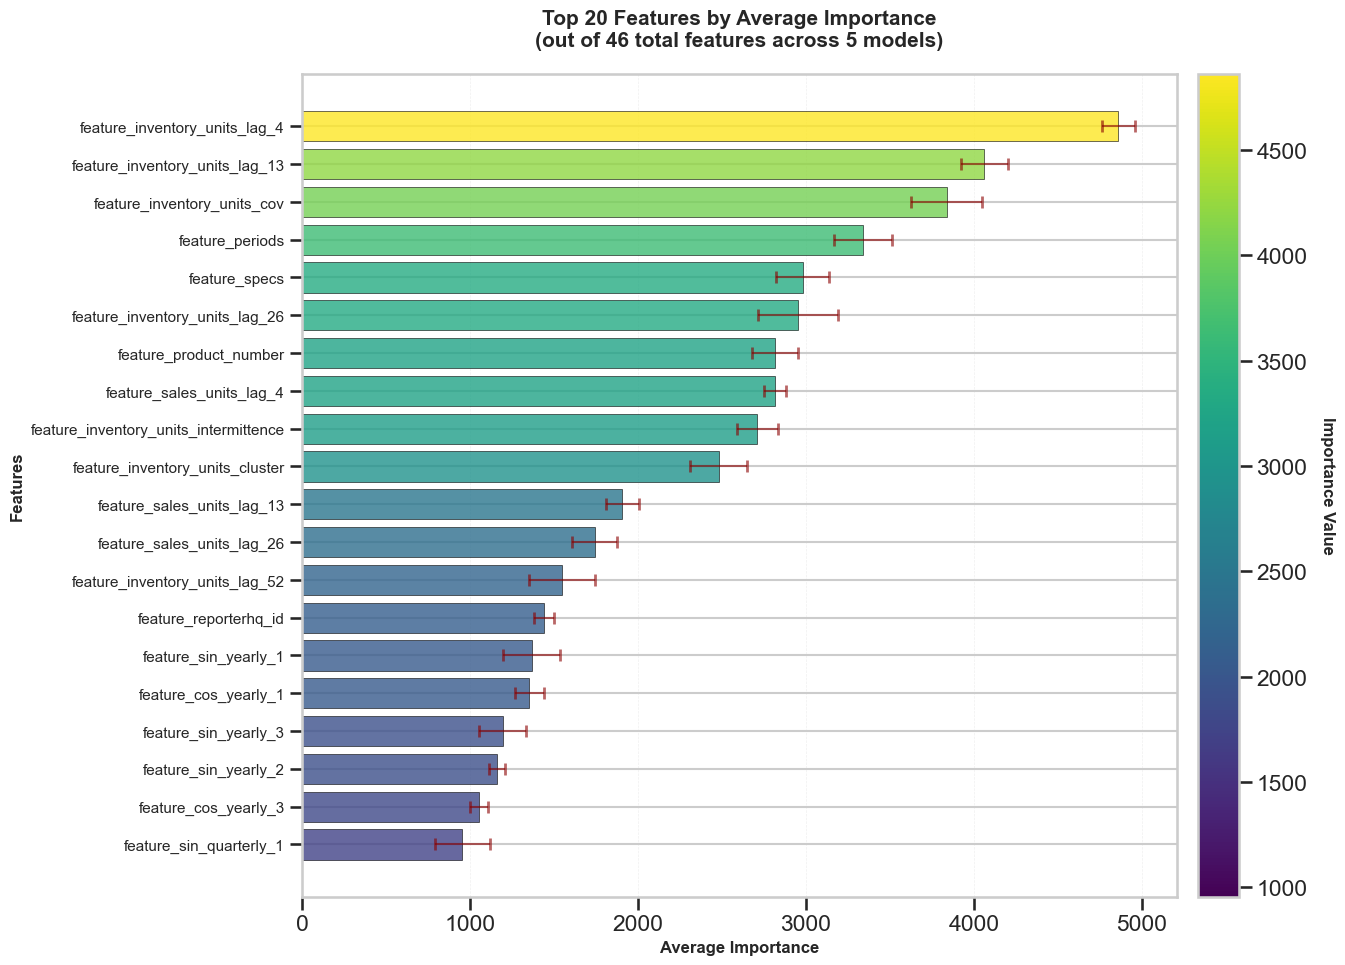

In [25]:
# Plot the average feature importance across all cutoffs
forecaster.plot_feature_importance(top_n=20)

# Guardrail

In [26]:
# Initialize the Guardrail class
guardrail = Guardrail()

In [27]:
# Create smart ensemble between ML predictions and Croston baseline
df_with_ensemble = guardrail.create_smart_ensemble(
    df=df_with_preds, 
    group_cols=group_columns_cb,
    pred_col="model_prediction", 
    baseline_col=f'baseline_{target_col}_croston',
    intermittence_threshold=50.0,
    cov_threshold=1.0,
    verbose=True
)

# Show
df_with_ensemble.head()


SMART ENSEMBLE GUARDRAIL
Prediction column: 'model_prediction'
Baseline column: 'baseline_inventory_units_croston'
Group columns: ['reporterhq_id', 'product_number', 'cutoff']
Intermittence threshold: 50.0%
CV threshold: 1.0
Using intermittence column: 'feature_inventory_units_intermittence'
Using CV column: 'feature_inventory_units_cov'

📊 Ensemble Summary:
   • Total groups: 2530
   • Groups using baseline: 632 (25.0%)
   • Groups using prediction: 1898 (75.0%)

🔍 Baseline Groups (high intermittence/CV):
   • Avg intermittence: 5.6%
   • Avg CV: 33.37
   • Rows affected: 26866

🎯 Prediction Groups (low intermittence/CV):
   • Avg intermittence: 3.2%
   • Avg CV: -12.49
   • Rows affected: 78748

✅ Smart ensemble created successfully!
   • New column: 'prediction_ensemble'
   • Total rows processed: 105614


,reporterhq_id,product_number,prod_category,specs,display_size,segment,date,sales_units,inventory_units,cutoff,sample,horizon,feature_reporterhq_id,feature_product_number,feature_prod_category,feature_specs,feature_display_size,feature_segment,feature_year,feature_quarter,feature_month,feature_week,feature_day,feature_dayofweek,feature_sin_yearly_1,feature_cos_yearly_1,feature_sin_yearly_2,feature_cos_yearly_2,feature_sin_yearly_3,feature_cos_yearly_3,feature_sin_quarterly_1,feature_cos_quarterly_1,feature_sin_quarterly_2,feature_cos_quarterly_2,feature_sin_monthly_1,feature_cos_monthly_1,feature_sin_monthly_2,feature_cos_monthly_2,feature_sin_weekly_1,feature_cos_weekly_1,feature_sin_weekly_2,feature_cos_weekly_2,feature_sin_weekly_3,feature_cos_weekly_3,feature_periods,feature_periods_expanding,feature_periods_sqrt,sales_units_ma_4,sales_units_ma_13,inventory_units_ma_4,inventory_units_ma_13,sales_units_min_4,sales_units_max_4,sales_units_mean_4,sales_units_min_13,sales_units_max_13,sales_units_mean_13,inventory_units_min_4,inventory_units_max_4,inventory_units_mean_4,inventory_units_min_13,inventory_units_max_13,inventory_units_mean_13,feature_sales_units_lag_4,feature_sales_units_lag_13,feature_sales_units_lag_26,feature_sales_units_lag_52,feature_inventory_units_lag_4,feature_inventory_units_lag_13,feature_inventory_units_lag_26,feature_inventory_units_lag_52,feature_inventory_units_cov,feature_inventory_units_intermittence,feature_inventory_units_cluster,train_weight,baseline_sales_units_ma_13,baseline_inventory_units_ma_13,baseline_sales_units_croston,baseline_inventory_units_croston,training_group,guardrail,prediction,model_prediction,prediction_ensemble
0,12,10857,Doraemon,108304,15.6,Gaming,2021-01-30,0.0,52.0,2023-01-07,train,0,0,7,4,9,6,1,2021,1,1,4,30,5,0.493468,0.869764,0.858402,0.512978,0.999745,0.022576,0.880683,-0.473706,-0.834370,-0.551205,-0.201299,0.979530,-0.394356,0.918958,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.62349,1.0,1.000000,1.000000,0.000000,0.000000,52.000000,52.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,52.0,52.0,52.000000,52.0,52.0,52.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.636072,2.970297,6,0.009901,0.000000,52.000000,0.000000,0.0000,1,False,74.977101,NaN,NaN
1,12,10857,Doraemon,108304,15.6,Gaming,2021-02-06,8.0,48.0,2023-01-07,train,0,0,7,4,9,6,1,2021,1,2,5,6,5,0.594376,0.804187,0.955979,0.293434,0.943196,-0.332235,0.561034,-0.827793,-0.928839,0.370483,0.974928,0.222521,0.433884,-0.900969,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.62349,2.0,2.143547,1.414214,4.000000,4.000000,50.000000,50.000000,0.0,8.0,4.000000,0.0,8.0,4.000000,48.0,52.0,50.000000,48.0,52.0,50.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.636072,2.970297,6,0.019802,4.000000,50.000000,0.800000,51.6000,1,False,75.723842,NaN,NaN
2,12,10857,Doraemon,108304,15.6,Gaming,2021-02-13,39.0,72.0,2023-01-07,train,0,0,7,4,9,6,1,2021,1,2,6,13,5,0.686676,0.726964,0.998377,0.056952,0.764891,-0.644159,0.113720,-0.993513,-0.225964,0.974136,0.222521,-0.974928,-0.433884,0.900969,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.62349,3.0,3.348370,1.732051,15.666667,15.666667,57.333333,57.333333,0.0,39.0,15.666667,0.0,39.0,15.666667,48.0,72.0,57.333333,48.0,72.0,57.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.636072,2.970297,6,0.029703,15.666667,57.333333,4.620000,53.6400,1,False,77.467686,NaN,NaN
3,12,10857,Doraemon,108304,15.6,Gaming,2021-02-20,0.0,138.0,2023-01-07,train,0,0,7,4,9,6,1,2021,1,2,7,20,5,0.769031,0.639212,0.983147,-0.182817,0.487847,-0.872929,-0.359472,-0.933156,0.670887,0.741560,-0.974928,-0.222521,0.433884,-0.900969,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.62349,4.0,4.594793,2.000000,11.750000,11.750000,77.500000,77.500000,0.0,39.0,11.750000,0.0,39.0,11.750000,48.0,138.0,77.500000,48.0,138.0,77.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.636072,2.970297,6,0.039604,11.750000,77.500000,4.620000,62.0760,1,False,79.641965,NaN,NaN
4,12,10857,Doraemon,108304,15.6,Gaming,2021-02-27,69.0,87.0,2023-01-07,train,0,0,7,4,9,6,1,2

## Run Evaluator

In [28]:
# Params
actuals_col = 'inventory_units'
baseline_col = 'baseline_inventory_units_ma_13'
preds_col = ['model_prediction', 'prediction', 'prediction_ensemble']

# Initialize the Evaluator class
evaluator = Evaluator(df_with_ensemble, actuals_col, baseline_col, preds_col)

# Call the function
metric_table = evaluator.create_metric_table()

# Show
metric_table

,RMSE,MAE,MAPE,WMAPE,Custom Metric
baseline_inventory_units_ma_13,49.55,37.36,146.26,53.25,54.82
model_prediction,47.43,35.57,136.74,50.08,54.41
prediction,47.61,35.72,132.92,50.06,54.59
prediction_ensemble,49.84,37.08,163.75,52.20,55.97


## Lag metrics

In [29]:
# Params
metric_name = 'RMSE'
group_col = 'horizon'
group_filter = range(1,14)

# Call the function
lag_metrics = evaluator.calculate_grouped_metric(metric_name, group_col, group_filter)

# Show
lag_metrics

horizon,1,2,3,4,5,6,7,8,9,10,11,12,13
baseline_inventory_units_ma_13,46.23,30.71,26.89,26.07,9.5,50.66,51.03,46.27,43.35,21.62,51.88,52.87,62.50
model_prediction,43.38,58.72,62.18,53.89,11.2,47.71,47.33,47.11,51.82,27.82,48.91,48.50,59.96
prediction,43.51,58.72,62.18,53.89,11.2,47.93,47.33,47.11,51.82,27.82,49.09,48.82,59.96
prediction_ensemble,47.23,58.85,62.18,53.89,11.2,51.18,48.14,47.26,51.59,28.21,50.06,49.80,60.30


# Plot predictions


In [30]:
# Get the max cutoff
max_cutoff = df_with_preds['cutoff'].max()

# Filter the DataFrame where cutoff is equal to the max cutoff
df_filtered = df_with_preds[df_with_preds['cutoff'] == max_cutoff]

# Reset index
df_filtered = df_filtered.reset_index(drop=True)

# Show
df_filtered.head()

,reporterhq_id,product_number,prod_category,specs,display_size,segment,date,sales_units,inventory_units,cutoff,sample,horizon,feature_reporterhq_id,feature_product_number,feature_prod_category,feature_specs,feature_display_size,feature_segment,feature_year,feature_quarter,feature_month,feature_week,feature_day,feature_dayofweek,feature_sin_yearly_1,feature_cos_yearly_1,feature_sin_yearly_2,feature_cos_yearly_2,feature_sin_yearly_3,feature_cos_yearly_3,feature_sin_quarterly_1,feature_cos_quarterly_1,feature_sin_quarterly_2,feature_cos_quarterly_2,feature_sin_monthly_1,feature_cos_monthly_1,feature_sin_monthly_2,feature_cos_monthly_2,feature_sin_weekly_1,feature_cos_weekly_1,feature_sin_weekly_2,feature_cos_weekly_2,feature_sin_weekly_3,feature_cos_weekly_3,feature_periods,feature_periods_expanding,feature_periods_sqrt,sales_units_ma_4,sales_units_ma_13,inventory_units_ma_4,inventory_units_ma_13,sales_units_min_4,sales_units_max_4,sales_units_mean_4,sales_units_min_13,sales_units_max_13,sales_units_mean_13,inventory_units_min_4,inventory_units_max_4,inventory_units_mean_4,inventory_units_min_13,inventory_units_max_13,inventory_units_mean_13,feature_sales_units_lag_4,feature_sales_units_lag_13,feature_sales_units_lag_26,feature_sales_units_lag_52,feature_inventory_units_lag_4,feature_inventory_units_lag_13,feature_inventory_units_lag_26,feature_inventory_units_lag_52,feature_inventory_units_cov,feature_inventory_units_intermittence,feature_inventory_units_cluster,train_weight,baseline_sales_units_ma_13,baseline_inventory_units_ma_13,baseline_sales_units_croston,baseline_inventory_units_croston,training_group,guardrail,prediction,model_prediction
0,12,10857,Doraemon,108304,15.6,Gaming,2021-01-30,0.0,52.0,2023-05-06,train,0,0,7,4,9,6,1,2021,1,1,4,30,5,0.493468,0.869764,0.858402,0.512978,0.999745,0.022576,0.880683,-0.473706,-0.834370,-0.551205,-0.201299,0.979530,-0.394356,0.918958,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.62349,1.0,1.000000,1.000000,0.000000,0.000000,52.000000,52.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,52.0,52.0,52.000000,52.0,52.0,52.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.61267,2.564103,8,0.008547,0.000000,52.000000,0.000000,0.0000,1,False,78.229706,NaN
1,12,10857,Doraemon,108304,15.6,Gaming,2021-02-06,8.0,48.0,2023-05-06,train,0,0,7,4,9,6,1,2021,1,2,5,6,5,0.594376,0.804187,0.955979,0.293434,0.943196,-0.332235,0.561034,-0.827793,-0.928839,0.370483,0.974928,0.222521,0.433884,-0.900969,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.62349,2.0,2.143547,1.414214,4.000000,4.000000,50.000000,50.000000,0.0,8.0,4.000000,0.0,8.0,4.000000,48.0,52.0,50.000000,48.0,52.0,50.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.61267,2.564103,8,0.017094,4.000000,50.000000,0.800000,51.6000,1,False,76.366765,NaN
2,12,10857,Doraemon,108304,15.6,Gaming,2021-02-13,39.0,72.0,2023-05-06,train,0,0,7,4,9,6,1,2021,1,2,6,13,5,0.686676,0.726964,0.998377,0.056952,0.764891,-0.644159,0.113720,-0.993513,-0.225964,0.974136,0.222521,-0.974928,-0.433884,0.900969,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.62349,3.0,3.348370,1.732051,15.666667,15.666667,57.333333,57.333333,0.0,39.0,15.666667,0.0,39.0,15.666667,48.0,72.0,57.333333,48.0,72.0,57.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.61267,2.564103,8,0.025641,15.666667,57.333333,4.620000,53.6400,1,False,76.215167,NaN
3,12,10857,Doraemon,108304,15.6,Gaming,2021-02-20,0.0,138.0,2023-05-06,train,0,0,7,4,9,6,1,2021,1,2,7,20,5,0.769031,0.639212,0.983147,-0.182817,0.487847,-0.872929,-0.359472,-0.933156,0.670887,0.741560,-0.974928,-0.222521,0.433884,-0.900969,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.62349,4.0,4.594793,2.000000,11.750000,11.750000,77.500000,77.500000,0.0,39.0,11.750000,0.0,39.0,11.750000,48.0,138.0,77.500000,48.0,138.0,77.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.61267,2.564103,8,0.034188,11.750000,77.500000,4.620000,62.0760,1,False,77.812067,NaN
4,12,10857,Doraemon,108304,15.6,Gaming,2021-02-27,69.0,87.0,2023-05-06,train,0,0,7,4,9,6,1,2021,1,2,8,27,5,0.840248,0.542202,0.91116

In [31]:
# Params
baseline_col = 'baseline_inventory_units_ma_13'
target_col = 'inventory_units'

# Plots
top_n_plots = 6

## Plot by Reporter

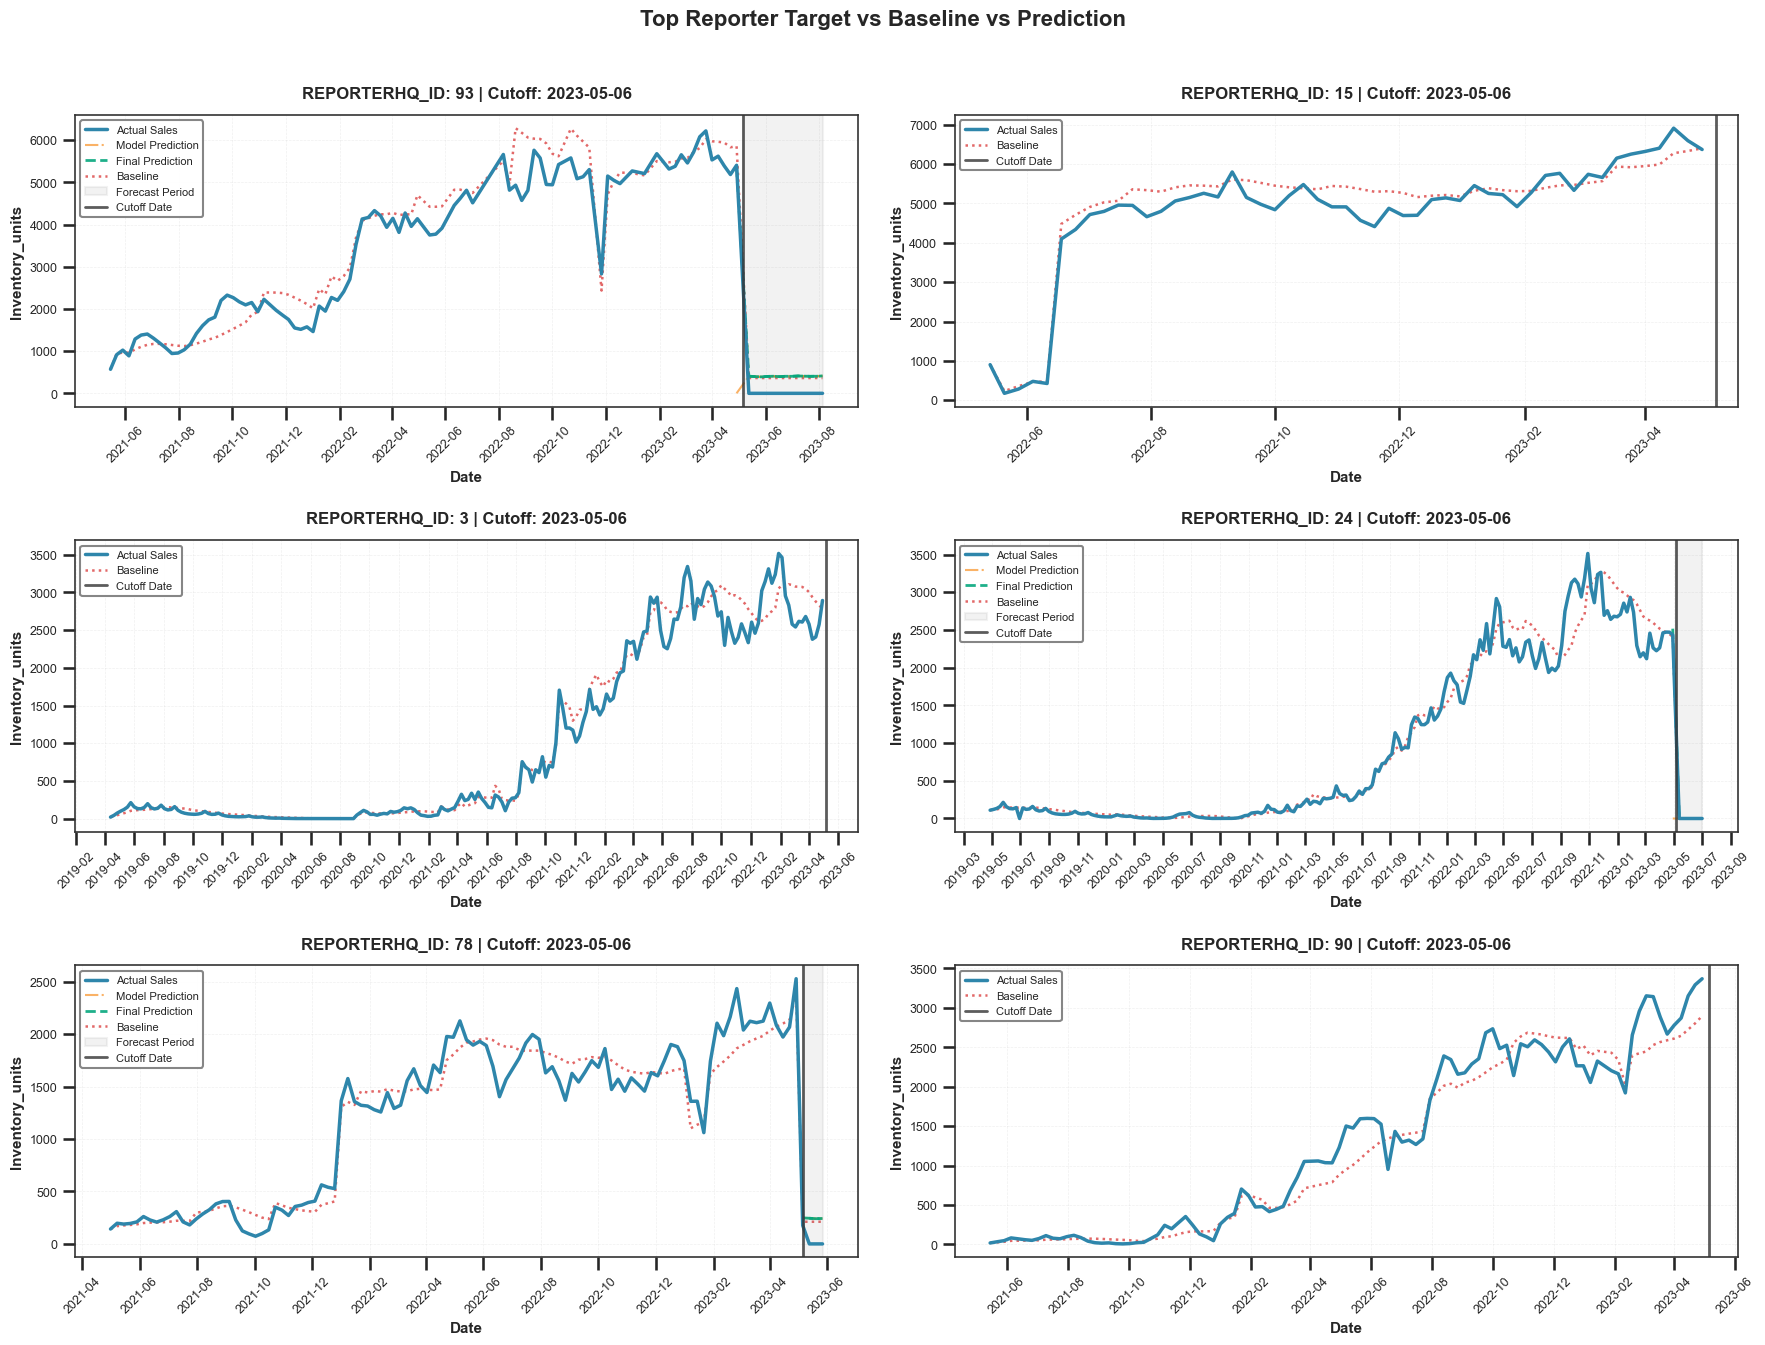

In [32]:
# Plot by client
process_and_plot(
    df_filtered,
    group_col='reporterhq_id',
    baseline_col=baseline_col,
    target_col=target_col,
    top_n=top_n_plots,
    title='Top Reporter Target vs Baseline vs Prediction'
)

## Plot by Product

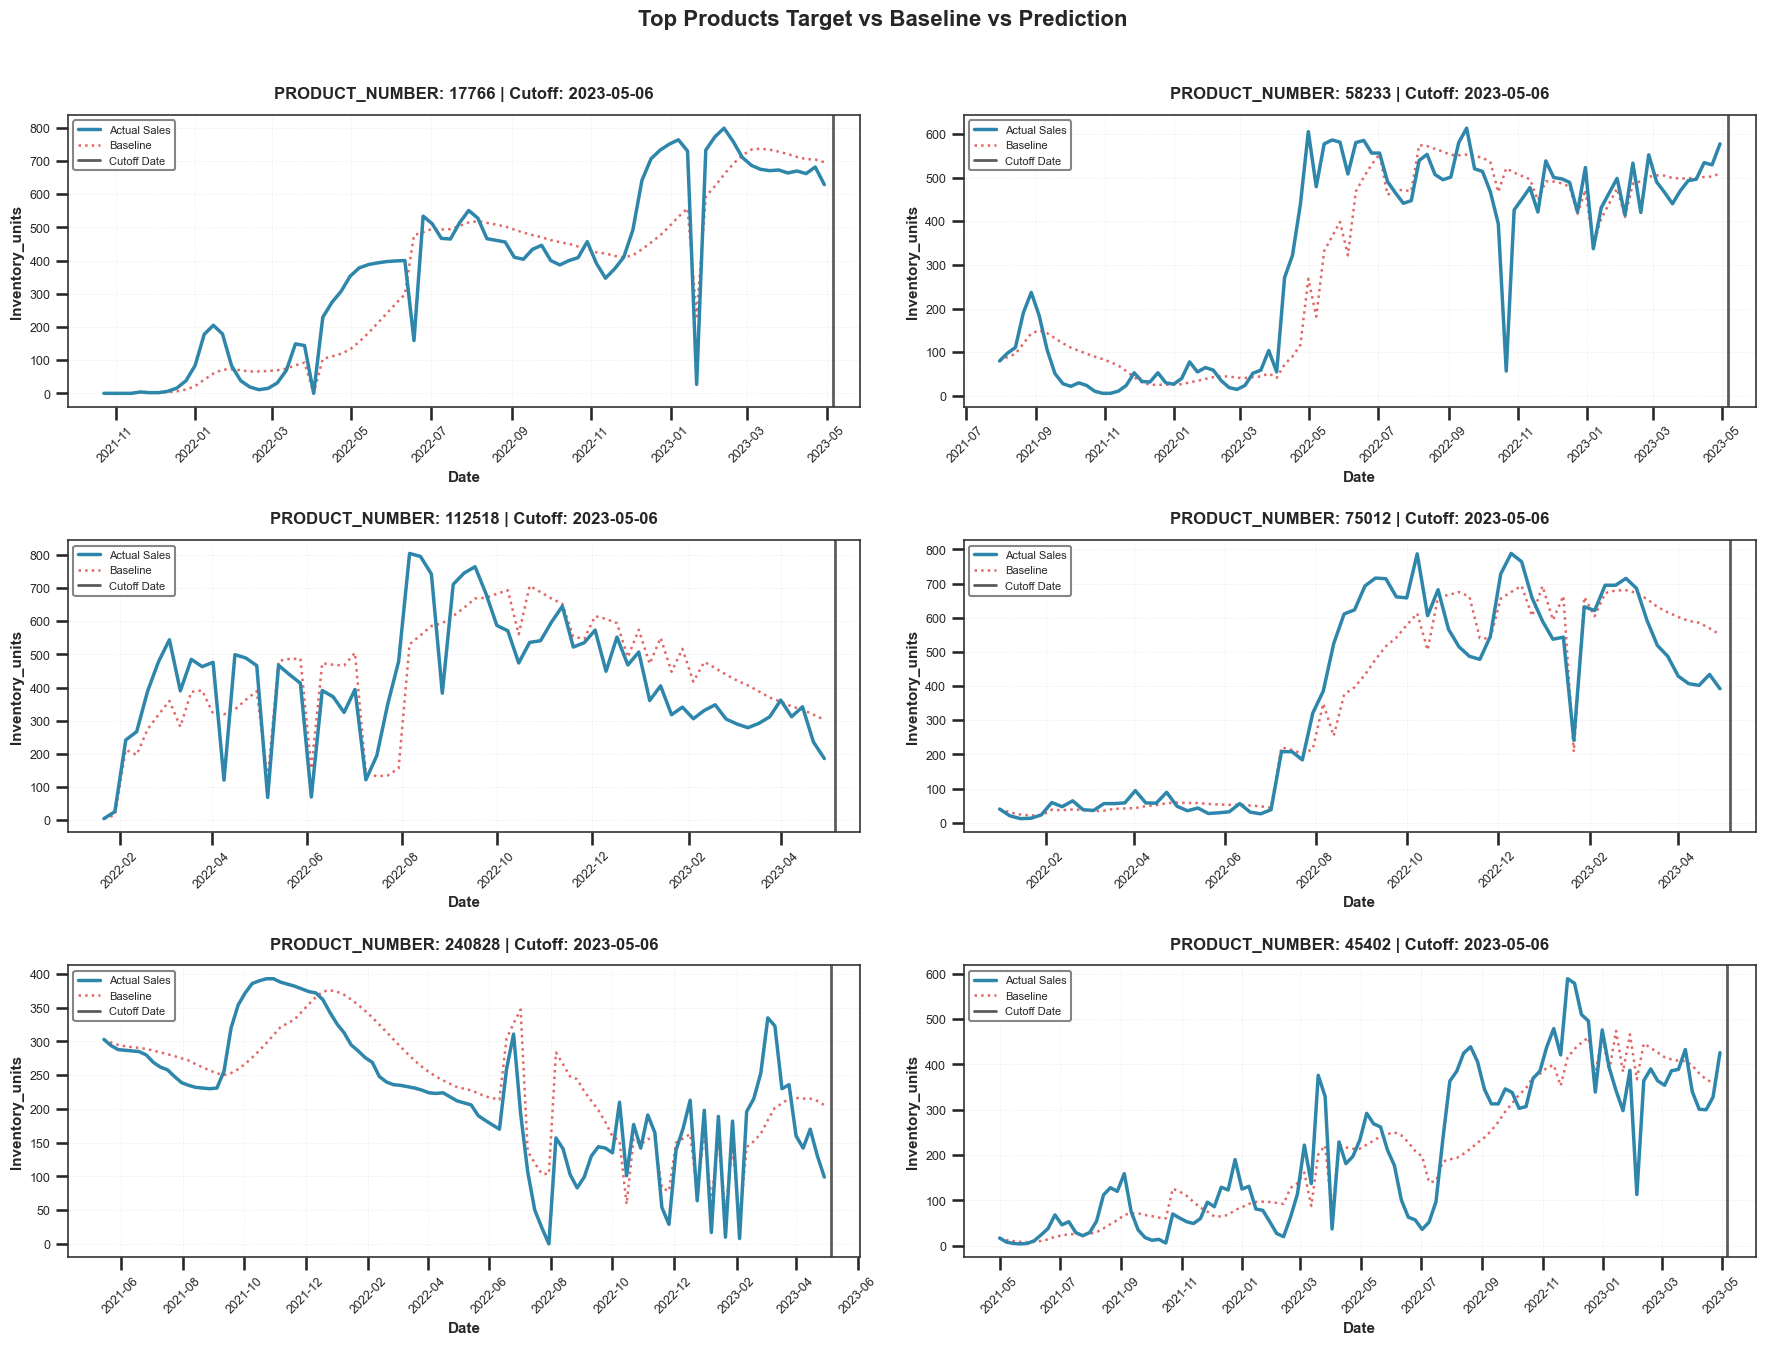

In [33]:
# Plot by product
process_and_plot(
    df_filtered,
    group_col='product_number',
    baseline_col=baseline_col,
    target_col=target_col,
    top_n=top_n_plots,
    title='Top Products Target vs Baseline vs Prediction'
)

# Save output

In [34]:
# Select columns
df_filtered = df_with_preds.loc[:, ~df_with_preds.columns.str.startswith('feature_')]

# Create the filename with the phase appended
file_name = f'outputs/predictions.csv'

# Write the dataframe to the CSV file
df_filtered.to_csv(file_name, index=False)

# Clean

In [35]:
# Garbage collection
gc.collect()

54562